In [2]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy import io, stats

In [3]:
# Load and mean-shift the data
eruptions = scipy.io.loadmat('old_faithful.mat')['data']
eruptions = eruptions - np.mean(eruptions, axis=0)

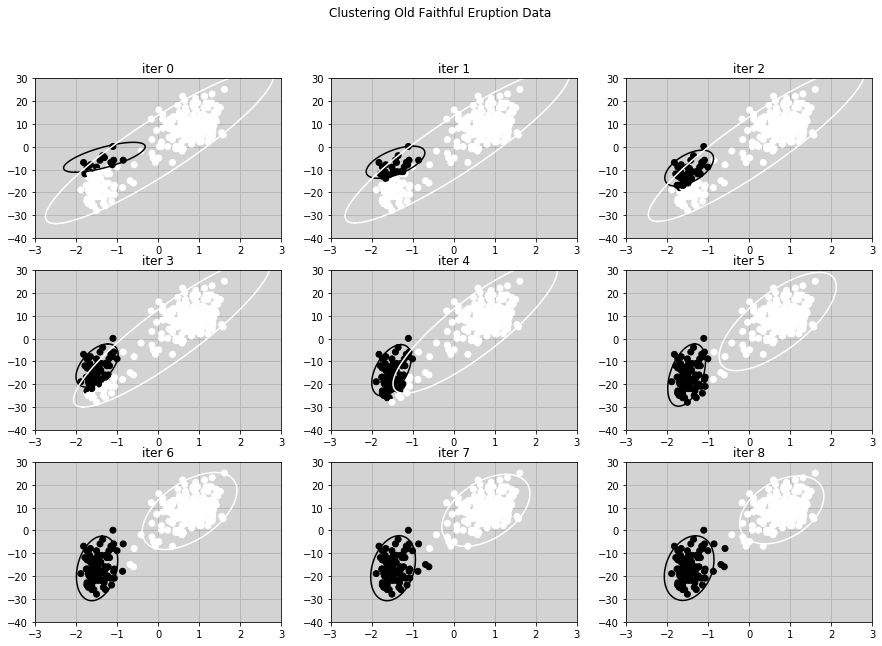

In [5]:
def plot_eruptions(eruptions, means, variances, ax, title=None):
    """
    Parameters:
        eruptions ((n,2) ndarray): The n points to cluster into two classes.
        means ((2,2) ndarray): The 2 means of each class. A point is a row.
        variances((2,2,2) ndarray): The covariance matrix for each class.
    """
    n = eruptions.shape[0]
    ax.set_facecolor('lightgray')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-40, 30])
    ax.grid(True)
    ax.set_axisbelow(True)
    prob1 = pdf(eruptions, means[0], variances[0])
    prob2 = pdf(eruptions, means[1], variances[1])
    class1_prob = prob1/(prob1+prob2)
    color = np.zeros((n,4))
    for i in range(n):
        if class1_prob[i] > 0.5:
            color[i,:] = np.array([0,0,0,1])
        else:
            color[i,:] = np.array([1,1,1,1])
    ax.scatter(eruptions[:,0], eruptions[:,1], color=color)
    ax.scatter(means[0,0], means[0,1], color='black')
    ax.scatter(means[1,0], means[1,1], color='white')
    cov_pts1, cov_pts2 = cov_to_pts(cov=variances[0]), cov_to_pts(cov=variances[1])
    cov_pts1 += means[0]
    cov_pts2 += means[1]
    ax.plot(cov_pts1[:,0], cov_pts1[:,1], color='black')
    ax.plot(cov_pts2[:,0], cov_pts2[:,1], color='white')
    if title:
        ax.set_title(title)
    
def pdf(point, mean, cov):
    """
    Parameters:
        point ((n,2) ndarray): the (x,y) points.
        mean ((2,) ndarray): the Gaussian mean.
        variance ((2,2) ndarray): the Gaussian covariance matrix.
    Returns:
        p ((n,) ndarray): the probability that point was generated from a Gaussian with the given mean and variance.
    """
    return scipy.stats.multivariate_normal.pdf(point, mean=mean, cov=cov)

def cov_to_pts(cov):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(pmat, sf).T # returns (100,n)

def em(eruptions, mus, covs, mws):
    # find responsibilities and mixing weights
    prob1 = pdf(eruptions, mus[0], covs[0])
    prob2 = pdf(eruptions, mus[1], covs[1])
    resp = prob1 > prob2 # responsibilities
    tao = np.where(resp, prob1, prob2) / (prob1+prob2) # mixing weights
    tao_sum1 = np.sum(tao[resp])
    tao_sum2 = np.sum(tao[~resp])
    # update sample means
    mus[0] = np.sum((tao[resp]*eruptions[resp,:].T).T, axis=0) / tao_sum1
    mus[1] = np.sum((tao[~resp]*eruptions[~resp,:].T).T, axis=0) / tao_sum2
    # update sample variances
    covs[0] = get_covariance(mus[0], eruptions[resp,:], tao[resp])
    covs[1] = get_covariance(mus[1], eruptions[~resp,:], tao[~resp])
    
def get_covariance(mu, points, tao):
    """ Assumes that points and tao are already sorted by class. """
    x_variance = np.sum(tao*(mu[0]-points[:,0])**2) / np.sum(tao)
    y_variance = np.sum(tao*(mu[1]-points[:,1])**2) / np.sum(tao)
    xy_cov = np.sum(tao*(mu[0]-points[:,0])*(mu[1]-points[:,1])) / np.sum(tao)
    return np.array([
        [x_variance, xy_cov],
        [xy_cov, y_variance]
    ])
   
    
fig, axs = plt.subplots(3, 3, figsize=(15,10))

mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]]).T # each mean is a row vector now
covs = np.asarray([[[ 0.74072815,  0.09252716],
                    [ 0.09252716,  0.5966275 ]],
                   [[ 0.39312776, -0.46488887],
                    [-0.46488887,  1.64990767]]])
mws = [ 0.68618439, 0.31381561 ]  # called alpha in the slides

j = 0
for i in range(34):
    em(eruptions=eruptions, mus=mus, covs=covs, mws=mws)
    if i < 9:
        plot_eruptions(eruptions=eruptions, means=mus, variances=covs, ax=axs[j//3, j%3], title="iter {}".format(i))
        j += 1
        
plt.suptitle("Clustering Old Faithful Eruption Data")
plt.show()